# Delta Omicron multidms data fit

# Peek at Delta / Omicron Data

This notebook is quite computationally expensive, I run it on the Ermine node

## Outline

1. Import Dependencies
2. Prep Data
    - downsample (calling function)
    - aggregate?
    - create_homolog_modeling_data()
3. Fit Data and summarize results
    - Sigmoid accuracy
    - Parameter distributions
    - Parameter Heatmaps

## Import `Python` modules

In [1]:
import os
import math
import pandas as pd
import re
import json
import binarymap as bmap
import matplotlib.pyplot as plt
import seaborn as sns
import jax
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
from jax.experimental import sparse
from jaxopt import ProximalGradient
import jaxopt
import numpy as onp
from scipy.stats import pearsonr
from scipy.stats import poisson

from timeit import default_timer as timer
%matplotlib inline

import sys
sys.path.append("..")
from multidms.utils import create_homolog_modeling_data, initialize_model_params
from multidms.model import ϕ, g, prox, cost_smooth

## Read in metadata on homolog DMS experiments

Our primary goal is to get a single dataframe that contains all homolog variants encoded with sequencial sites wrt the wt seqences which have been aligned with no gaps - as well as their functional scores. This can then be converted into our model fitting data.

We'll start by collecting all the data for each homolog into a single dataframe containing all experiments
along with a column holding a nested dataframe for all the associated functional scores.

Additionally, we make a dictionary for the homolog wildtype sequences, and a df for the site maps of both sequences

In [18]:
if subset_data:
    func_score_df = func_score_df.sample(n=subset_data, random_state=23).reset_index()
if agg_variants:
    func_score_df = func_score_df.groupby([subs_col, homolog_column]).mean().reset_index()
    func_score_df["pre_count"] = func_score_df["pre_count"].astype(int)
    func_score_df["post_count"] = func_score_df["post_count"].astype(int)

Option to subset the data to just the reference homolog.

In [19]:
if False:
    func_score_df = func_score_df[
        (func_score_df[homolog_column] == reference_homolog)
    ]

Create a new dataframe in which mutations are all relative to the reference homolog.

In [27]:
(X, y), df, all_subs, site_map = create_homolog_modeling_data(
                            func_score_df, #.sample(100), 
                            homolog_column,
                            reference_homolog,
                            subs_col,
                            func_score_col
                        )

Found 8 site(s) lacking data in at least one homolog.
2817 of the 88753 variants were removed because they had mutations at the above sites, leaving 85936 variants.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59537/59537 [01:57<00:00, 506.59it/s]


There were 0 cache hits in total for homolog Omicron_BA.1-3-1.


In [28]:
print('Number of datapoints per homolog:')
for (homolog, data) in df.groupby(homolog_column):
    print(homolog, len(data))

Number of datapoints per homolog:
Delta-3-1 26399
Omicron_BA.1-3-1 59537


Fit models

In [128]:
# Params for fitting
maxiter = 5000 # 
# λ_ridge = 0
λ_lasso=5e-5
λ_ridge=0
clip_str = "-".join([str(c) for c in clip_y]) if clip_y else clip_y
fig_saveas_prefix = (f"tar-{func_score_col}-clipy-{clip_str}"
                    f"-ref-{reference_homolog}"
                    f"-agg-{agg_variants}"
                    f"-sub-{subset_data}"
                    f"-iter-{maxiter}-λ_ridge-{λ_ridge}-λ_lasso-{λ_lasso}")

# Initialize the range and minimum of the sigmoid
# from the global epistasis function using the 5th
# and 95th percentile values from the raw data
sig_upper = df[func_score_col].quantile(0.95)
sig_lower = df[func_score_col].quantile(0.05)
sig_range = sig_upper - sig_lower

# Initialize all params
params = initialize_model_params(
    func_score_df[homolog_column].unique(), 
    n_beta_shift_params=X[reference_homolog].shape[1],
    include_alpha=True,
    init_sig_range=sig_range,
    init_sig_min=sig_lower
)

In [129]:
print(f"\nPre-Optimization")
print(f"----------------")
print(f"cost = {cost_smooth(params, (X, y), λ_ridge=0):.2e}")


Pre-Optimization
----------------
cost = 2.96e+00


In [130]:
tol = 1e-6
maxiter = maxiter
start = timer()
solver = ProximalGradient(cost_smooth, prox, tol=tol, maxiter=maxiter)

# First, just fit data on reference homolog
# if False:
#     print('Fitting model to just the reference homolog')
#     params, state = solver.run(
#         params, 
#         hyperparams_prox = dict(
#             clip_stretch=0.0, 
#             lock_params= {
#                 f"S_{reference_homolog}" : jnp.zeros(len(params['β'])),
#                 f"C_{reference_homolog}" : jnp.zeros(shape=(1,)),
#                 f"C_{homolog_2}" : jnp.zeros(shape=(1,))
#             },
#         ),
#         data=(
#             {reference_homolog : X[reference_homolog]},
#             {reference_homolog : y[reference_homolog]}
#         ),
#         λ_ridge=0
#     )

# Next, jointly fit data on both homologs
print('Fitting model to both homologs')
params, state = solver.run(
    params, 
    hyperparams_prox = dict(
        lasso_params={f"S_{homolog_2}" : λ_lasso},
        lock_params= {
            f"S_{reference_homolog}" : jnp.zeros(len(params['β'])),
            f"C_{reference_homolog}" : jnp.zeros(shape=(1,)),
            f"C_{homolog_2}" : jnp.zeros(shape=(1,))
        }
    ),
    data=(X, y),
    λ_ridge=λ_ridge
)
end = timer()

print(f"\nPost-Optimization")
print(f"-----------------")
print(f"Full model optimization: {state.iter_num} iterations")
print(f"error = {state.error:.2e}")
print(f"cost = {cost_smooth(params, (X, y)):.2e}")
print(f"Wall time for fit: {end - start}")

Fitting model to both homologs

Post-Optimization
-----------------
Full model optimization: 5000 iterations
error = 1.77e-03
cost = 6.41e-01
Wall time for fit: 55.291806989349425


Print summary stats of fit params

In [131]:
for param in ["β", f"S_{reference_homolog}", f"S_{homolog_2}"]:
    print(f"\nFit {param} distribution\n===============")
    if param not in params:
        continue
    arr = onp.array(params[param])
    mean = onp.mean(arr)
    median = onp.median(arr)
     
    # measures of dispersion
    min = onp.amin(arr)
    max = onp.amax(arr)
    range = onp.ptp(arr)
    variance = onp.var(arr)
    sd = onp.std(arr)
     
    print("Descriptive analysis")
    print("Measures of Central Tendency")
    print(f"Mean = {mean:.2e}")
    print(f"Median = {median:.2e}")
    print("Measures of Dispersion")
    print(f"Minimum = {min:.2e}")
    print(f"Maximum = {max:.2e}")
    print(f"Range = {range:.2e}")
    print(f"Variance = {variance:.2e}")
    print(f"Standard Deviation = {sd:.2e}")
    
if f'C_{homolog_2}' in params:
    print(f"\nC_{homolog_2}: {params[f'C_{homolog_2}']}")

print(f"\nFit Sigmoid Parameters, α\n================")
for param, value in params['α'].items():
    print(f"{param}: {value}") 

df["predicted_latent_phenotype"] = onp.nan
df[f"predicted_{func_score_col}"] = onp.nan

print(f"\nRunning Predictions")
print(f"-------------------")
for homolog, hdf in df.groupby(homolog_column):
    h_params = {"β":params["β"], "S":params[f"S_{homolog}"], "C":params[f"C_{homolog}"]}
    z_h = ϕ(h_params, X[homolog])
    df.loc[hdf.index, "predicted_latent_phenotype"] = z_h
    y_h_pred = g(params["α"], z_h)
    df.loc[hdf.index, f"predicted_{func_score_col}"] = y_h_pred

print(f"Done")


Fit β distribution
Descriptive analysis
Measures of Central Tendency
Mean = -1.63e+00
Median = -9.01e-01
Measures of Dispersion
Minimum = -1.35e+01
Maximum = 8.09e+00
Range = 2.16e+01
Variance = 6.60e+00
Standard Deviation = 2.57e+00

Fit S_Delta-3-1 distribution
Descriptive analysis
Measures of Central Tendency
Mean = 0.00e+00
Median = 0.00e+00
Measures of Dispersion
Minimum = 0.00e+00
Maximum = 0.00e+00
Range = 0.00e+00
Variance = 0.00e+00
Standard Deviation = 0.00e+00

Fit S_Omicron_BA.1-3-1 distribution
Descriptive analysis
Measures of Central Tendency
Mean = -1.43e-03
Median = 0.00e+00
Measures of Dispersion
Minimum = -2.30e+00
Maximum = 2.32e+00
Range = 4.61e+00
Variance = 2.93e-02
Standard Deviation = 1.71e-01

C_Omicron_BA.1-3-1: [0.]

Fit Sigmoid Parameters, α
ge_bias: [-3.07297121]
ge_scale: [3.06974794]
latent_bias: [3.27409172]

Running Predictions
-------------------
Done


Plot predicted vs. observed values

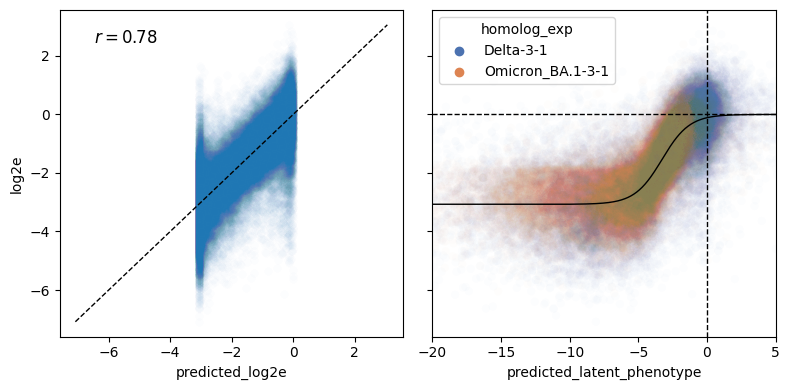

In [132]:
fig, ax = plt.subplots(1, 2, figsize=[8, 4], sharey=True)
sns.scatterplot(
    data=df, x=f"predicted_{func_score_col}",
    y=func_score_col,
    #hue=homolog_column,
    alpha=0.01, palette="deep", ax=ax[0],
    legend=True
)

lb = df[[func_score_col, f"predicted_{func_score_col}"]].min().min()
ub = df[[func_score_col, f"predicted_{func_score_col}"]].max().max()

ax[0].plot([lb, ub], [lb, ub], "k--", lw=1)
r = pearsonr(df[func_score_col], df[f'predicted_{func_score_col}'])[0]
ax[0].annotate(f"$r = {r:.2f}$", (.1, .9), xycoords="axes fraction", fontsize=12)

# shape 
sns.scatterplot(
    data=df, x="predicted_latent_phenotype",
    y=func_score_col,
    hue=homolog_column,
    alpha=0.01, palette="deep",
    legend=True, ax=ax[1]
)

ϕ_grid = onp.linspace(
    1.1 * df.predicted_latent_phenotype.min(),
    1.1 * df.predicted_latent_phenotype.max(),
    num=1000
)
shape = (ϕ_grid, g(params["α"], ϕ_grid))
ax[1].plot(*shape, color='k', lw=1)
#ax[1].set_ylim(-11, 1)
ax[1].set_xlim(-20, 5)
plt.axhline(0, color="k", ls="--", lw=1)
plt.axvline(0, color="k", ls="--", lw=1)
fig.savefig(f"{fig_saveas_prefix}-scatter.png")
plt.tight_layout()
#sns.despine()
plt.show()

**Observations**
* For jointly fitting delta/omicron data, the sigmoid often maxes out below 0. Could this be because extreme outliers are dragging it down? Is there a better loss function that would help resolve this?

Plot the distribution of beta and shift parameters.

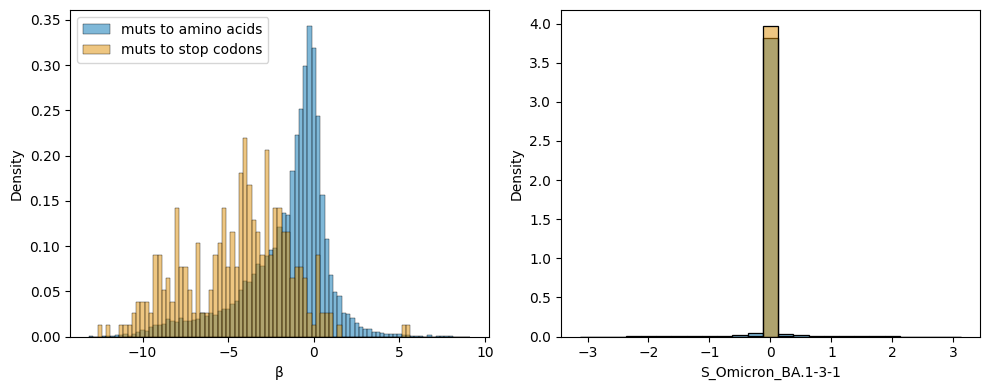

In [133]:
# Make a dataframe with inferred mutational effects
def split_sub(sub_string):
    """String match the wt, site, and sub aa
    in a given string denoting a single substitution"""

    pattern = r'(?P<aawt>[A-Z\*])(?P<site>[\d\w]+)(?P<aamut>[A-Z\*])'
    match = re.search(pattern, sub_string)
    assert match != None, sub_string
    return match.group('aawt'), match.group('site'), match.group('aamut')

mut_effects_dict = {
    key : []
    for key in ['wt', 'site', 'mut', 'param', 'param_val']
}
for (i, param) in enumerate(["β", f"S_{homolog_2}"]):
    if param in params:
        for (mutation, param_val) in zip(all_subs, params[param]):
            (wt, site, mut) = split_sub(mutation)
            mut_effects_dict['wt'].append(wt)
            mut_effects_dict['site'].append(int(site))
            mut_effects_dict['mut'].append(mut)
            mut_effects_dict['param'].append(param)
            mut_effects_dict['param_val'].append(float(param_val))
        
mut_effects_df = pd.DataFrame(mut_effects_dict)

(fig, axs) = plt.subplots(ncols=2, figsize=[10,4])
for (i, param) in enumerate(["β", f"S_{homolog_2}"]):
    
    # Plot data for all mutations
    data = mut_effects_df[
        (mut_effects_df['mut'] != '*') &
        (mut_effects_df['param'] == param)
    ]
    bin_width = 0.25
    min_val = math.floor(data['param_val'].min()) - 0.25/2
    max_val = math.ceil(data['param_val'].max())
    sns.histplot(
        x='param_val', data=data, ax=axs[i],
        stat='density', color=pal.as_hex()[0],
        label='muts to amino acids',
        binwidth=bin_width, binrange=(min_val, max_val),
        alpha=0.5
    )
    
    # Plot data for mutations leading to stop codons
    data = mut_effects_df[
        (mut_effects_df['mut'] == '*') &
        (mut_effects_df['param'] == param)
    ]
    sns.histplot(
        x='param_val', data=data, ax=axs[i],
        stat='density', color=pal.as_hex()[1],
        label='muts to stop codons',
        binwidth=bin_width, binrange=(min_val, max_val),
        alpha=0.5
    )
    
    axs[i].set(xlabel=param)

plt.tight_layout()
axs[0].legend()
fig.savefig(f"{fig_saveas_prefix}-hist.png")
plt.show()

To do for presenting to Jesse and Bernadeta:
* discuss w/ Jared:
    * differences between w/in homolog comparisons
    * new fitting strategy?
        * fit each homolog independently, then initialize joint fit with betas of reference?
        * come up w/ way to make datasets comparable
        * compare position of wt on sigmoid
        * add param to shift functional scores in non-reference homolog (could do this based on difference of wt on sigmoid?)
    * change loss function to be less sensitive to outliers? And to force sigmoid to go through the origin?

* updates for Jared
    * wildtype for omicron was getting filtered out! Due to indices being duplicated in many cases
    
* Question for 

In [ ]:
non_identical_sites = [
    int(i) for i, row in site_map.iterrows()
    if row[homolog_1] != row[homolog_2]
]

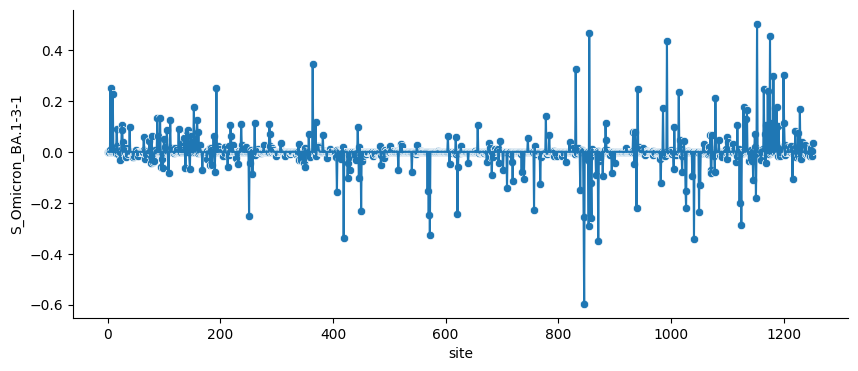

,site,param_val


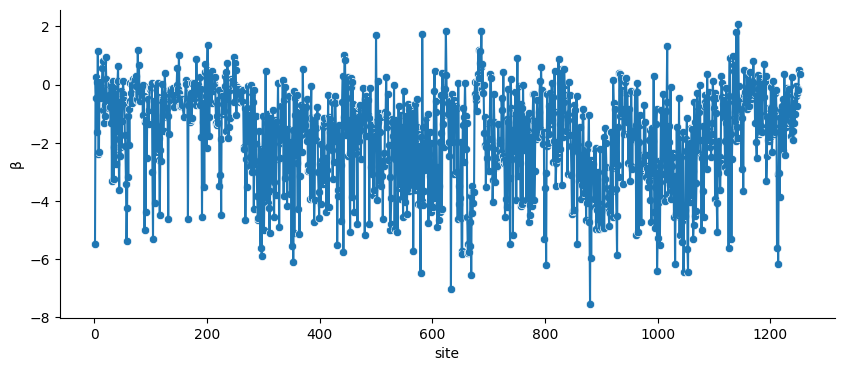

,site,param_val
0,1,-5.483881
30,31,-3.322073
33,34,-3.233719
43,44,-3.626812
55,56,-3.411907
56,57,-5.377362
57,58,-4.252797
59,60,-3.188481
86,89,-5.011706
88,91,-4.378321


In [134]:
params_to_plot = [f'S_{homolog_2}', 'β']
for param in params_to_plot:
    data = mut_effects_df[
        #(mut_effects_df['site'].between(800, 1200)) &
        (mut_effects_df['param'] == param)
    ]
    data = data.groupby('site').mean().reset_index()
    plt.figure(figsize=[10,4])
    sns.lineplot(x='site', y='param_val', data=data)
    sns.scatterplot(x='site', y='param_val', data=data)
    plt.ylabel(param)
    sns.despine()
    plt.show()
    display(data[data['param_val'] < -3].head(10))

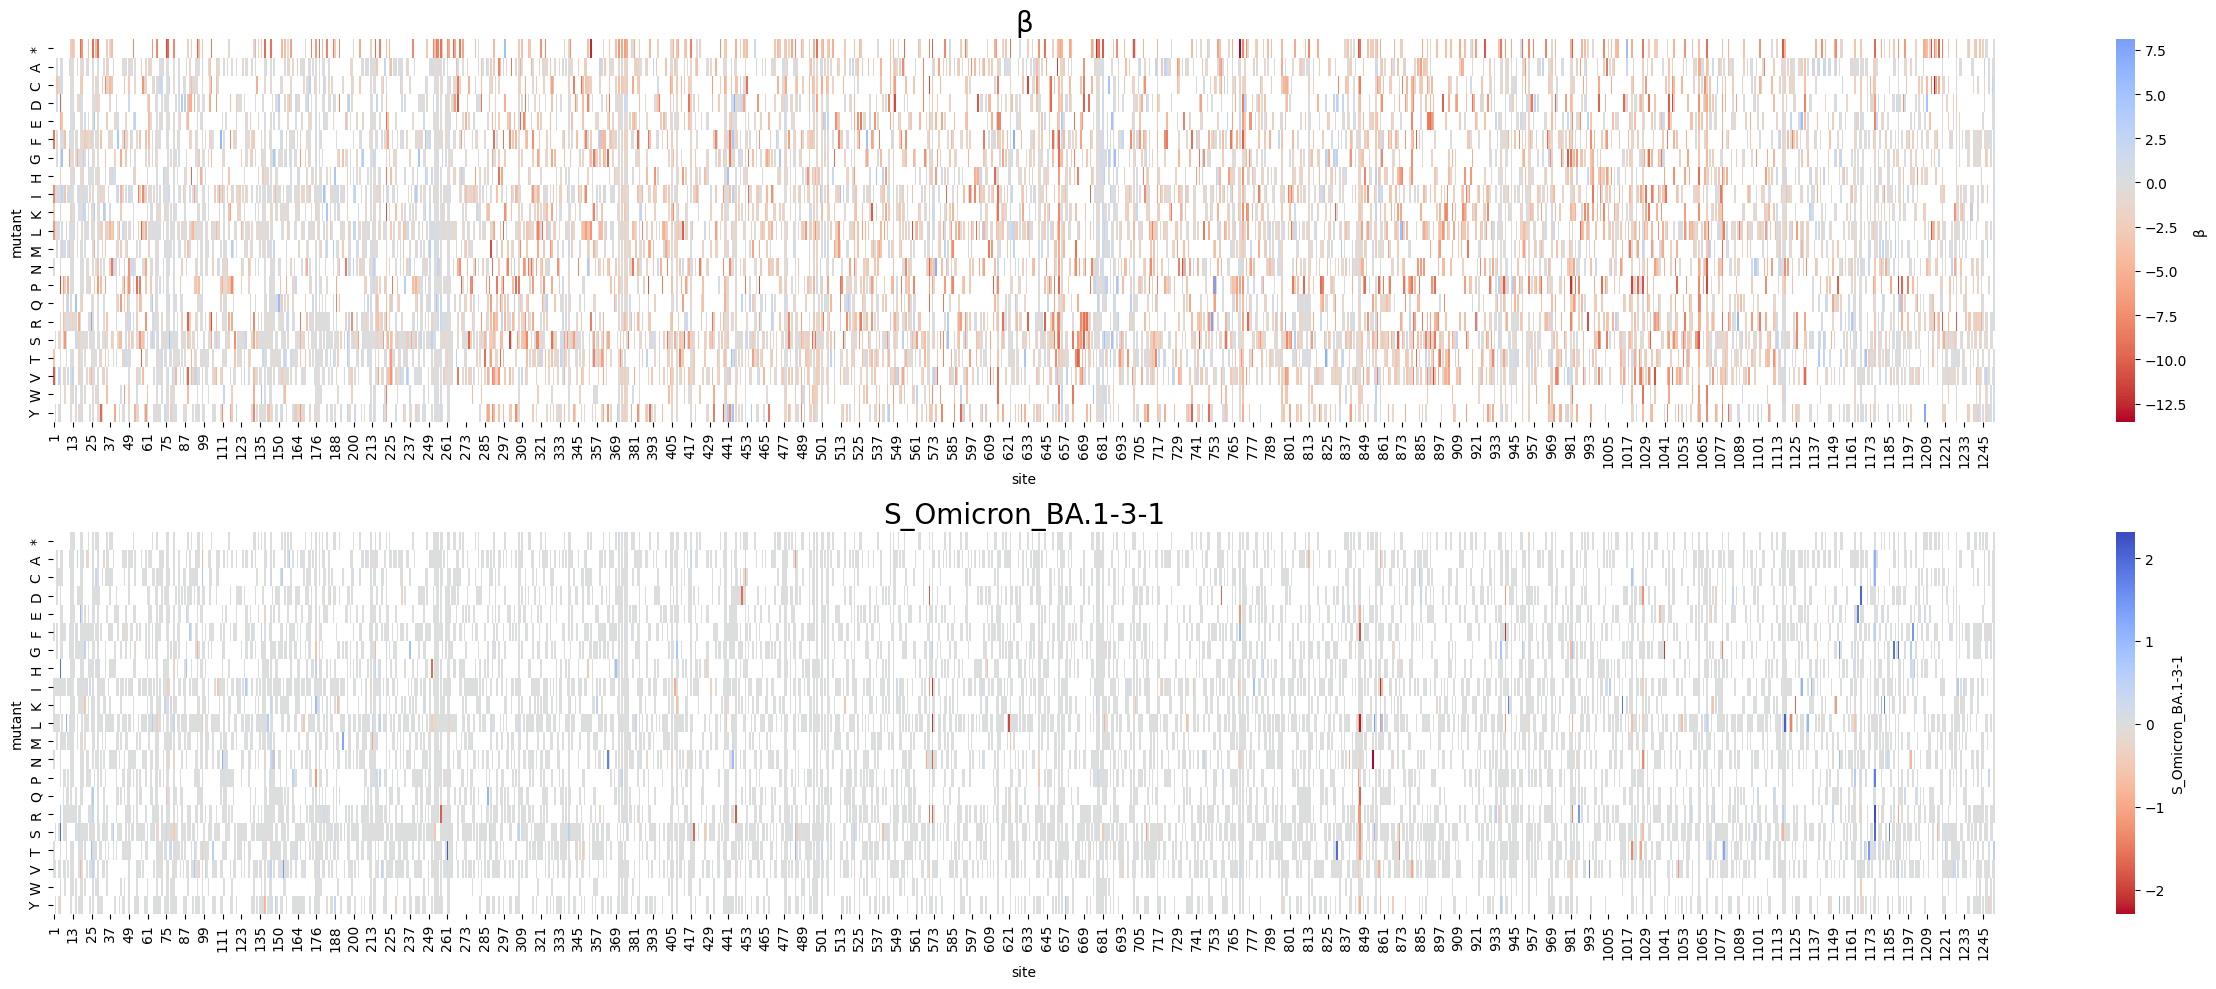

In [135]:
%matplotlib inline

fig, ax = plt.subplots(2, figsize=(25, 10))

def split_sub(sub_string):
    """String match the wt, site, and sub aa
    in a given string denoting a single substitution"""

    pattern = r'(?P<aawt>[A-Z\*])(?P<site>[\d\w]+)(?P<aamut>[A-Z\*])'
    match = re.search(pattern, sub_string)
    assert match != None, sub_string
    return match.group('aawt'), match.group('site'), match.group('aamut')

for i, param in enumerate(["β", f"S_{homolog_2}"]):
    rows = []
    for mutation, p in zip(all_subs, params[param]):
        wt, site, mut = split_sub(mutation)
        rows.append([int(site), wt, mut, float(p)])
        
    mutation_effects = pd.DataFrame(
        rows,
        columns=("site", "wildtype", "mutant", param)
    ).pivot(
        index="mutant",
        columns="site", values=param
    )# .iloc[:, 825:875]
    
    sns.heatmap(
        mutation_effects, 
        mask=mutation_effects.isnull(),
        cmap="coolwarm_r",
        center=0,
        cbar_kws={"label": param},
        ax=ax[i]
    )
    ax[i].set_title(f"{param}", size=20)

# for axes in ax:
#     for site in non_identical_sites:
#         axes.add_patch(
#             plt.Rectangle(
#                 (site-1, 0), 1, 21, 
#                 linewidth=3, 
#                 edgecolor="black",
#                 fill=False
#             )
#         )
    
plt.tight_layout()
fig.savefig(f"{fig_saveas_prefix}-heatmap.png")
plt.show()

In [ ]:
# Plot data
# min_val = mut_effects_df['param_val'].min()
# max_val = mut_effects_df['param_val'].max()
# nbins = 20
# bin_size = (max_val - min_val) / nbins
# bins = onp.arange(min_val-bin_size/2, max_val+bin_size, bin_size)
# data = mut_effects_df[(mut_effects_df['mut'] == '*')]
# sns.histplot(x='param_val', data=data, hue='param', bins=bins)
# plt.tight_layout()
# sns.despine()
# plt.show()